<head>
  <link href="https://fonts.cdnfonts.com/css/pf-tempesta-seven" rel="stylesheet">
  <link rel="stylesheet" href="https://use.typekit.net/bbp6pmz.css">
</head>

# NBA API Stats




In the following, we want to forecast the future success of potential NBA players and their performance in the NBA draft, as well as ascertain which colleges tend to produce the most successful NBA players. We analyze and evaluate player and game statistics to ascertain patterns and trends that contribute to successful NBA transitions.


In [2]:
import pandas as pd
import numpy as np

from nba_api.stats.static import teams
from nba_api.stats.static import players
from nba_api.stats.endpoints import CommonTeamRoster
from nba_api.stats.endpoints import TeamPlayerDashboard
from nba_api.stats.endpoints import leaguedashteamstats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as clr
import plotly.express as px
import circlify
import math

import warnings
warnings.filterwarnings('ignore')



<div class="mycode">

We will primarily be using `nba_api.stats.endpoints` for each API endpoint supported by [stats.nba.com](https://stats.nba.com/). For example, we use API endpoints such as `commonplayerinfo`, `drafthistory`

</div>


### Getting Team and Player IDs

The package also includes utilities for fetching player and team information available under `nba_api.stats.static`.

In [3]:
# Fetch NBA teams and display logos
nba_teams = teams.get_teams()
print(f"Number of teams fetched: {len(nba_teams)}")
nba_teams_df = pd.DataFrame(nba_teams)

Number of teams fetched: 30


In [4]:
def generate_team_logo_url(team_id):
    return f"https://cdn.nba.com/logos/nba/{team_id}/primary/L/logo.svg"

def path_to_image_html(path):
    return f'<img src="{path}" width="50" >'

nba_teams_df['logo_url'] = nba_teams_df['id'].apply(generate_team_logo_url)

In [5]:
from IPython.display import display, HTML
html_table = nba_teams_df.head(6).to_html(escape=False, formatters=dict(logo_url=path_to_image_html))
display(HTML(html_table))

,id,full_name,abbreviation,nickname,city,state,year_founded,logo_url
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Georgia,1949,
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946,
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970,
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002,
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966,
5,1610612742,Dallas Mavericks,DAL,Mavericks,Dallas,Texas,1980,


#### Get All NBA Players 

In [6]:
# Fetch all NBA players
nba_players = players.get_players()
print(f"Number of players fetched: {len(nba_players)}")

nba_active_players = players.get_active_players()
print(f"Number of active players fetched: {len(nba_active_players)}")

Number of players fetched: 5034
Number of active players fetched: 615


----

## CommonTeamRoster

In [7]:
# Fetch team rosters
all_nba_teams = [team["id"] for team in nba_teams]
all_players_info = []

for team_id in all_nba_teams:
    common_team_roster = CommonTeamRoster(
        team_id=team_id,
        league_id_nullable='00',
        season='2023-24',
        timeout=200
    )
    team_roster_df = common_team_roster.get_data_frames()[0]
    all_players_info.append(team_roster_df)

all_players_info_df = pd.concat(all_players_info, ignore_index=True)
# all_players_info_df.to_csv("data/nba_players.csv",index=False)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
# all_players_info_df = pd.read_csv("data/nba_players.csv")
all_players_info_df.head()

,TeamID,SEASON,LeagueID,PLAYER,NICKNAME,PLAYER_SLUG,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID,HOW_ACQUIRED
0,1610612737,2023,00,Jalen Johnson,Jalen,jalen-johnson,1,F,6-8,219,"DEC 18, 2001",22.0,2,Duke,1630552,#20 Pick in 2021 Draft
1,1610612737,2023,00,Trent Forrest,Trent,trent-forrest,2,G,6-4,210,"JUN 12, 1998",26.0,3,Florida State,1630235,None
2,1610612737,2023,00,Seth Lundy,Seth,seth-lundy,3,G-F,6-4,220,"APR 02, 2000",24.0,R,Penn State,1641754,#46 Pick in 2023 Draft
3,1610612737,2023,00,Kobe Bufkin,Kobe,kobe-bufkin,4,G,6-5,195,"SEP 21, 2003",20.0,R,Michigan,1641723,#15 Pick in 2023 Draft
4,1610612737,2023,00,Dejounte Murray,Dejounte,dejounte-murray,5,G,6-5,180,"SEP 19, 1996",27.0,6,Washington,1627749,None


---

### Colleges

In [ ]:
# Analyze colleges
filtered_school_counts_df = all_players_info_df['SCHOOL'].value_counts()
filtered_school_counts_df = filtered_school_counts_df[filtered_school_counts_df > 1].reset_index()
filtered_school_counts_df.columns = ['SCHOOL', 'Count']

replacements = {'Southern California': 'Southern<br>California', 
                'North Carolina': 'North<br>Carolina', 'NBA G League Ignite': 'NBA<br>G League', 'State': 'St.'}

filtered_school_counts_df['SCHOOL'] = filtered_school_counts_df['SCHOOL'].replace(replacements, regex=True)

--

In [ ]:
def get_color(name, number):
    return list(sns.color_palette(palette=name, n_colors=number).as_hex())

# Create custom colormap and convert to a list of hex colors
cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#FDE3FE', '#E8E08D', '#FCA611', '#FB831E', '#FF4F2D', '#FA6094', '#1C3858'], N=len(filtered_school_counts_df))
colors = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

# Set the custom palette
custom_palette = sns.set_palette(sns.color_palette(colors))
pal_vi = get_color(custom_palette, len(filtered_school_counts_df))

In [ ]:
# compute circle positions:
circles = circlify.circlify(
    filtered_school_counts_df['Count'].tolist(),
    target_enclosure=circlify.Circle(x=0, y=0, r=1),
    show_enclosure=False
)

bubble_df = pd.DataFrame({
    'x': [cir.x for cir in circles],
    'y': [cir.y for cir in circles],
    'r': [cir.r for cir in circles],
    'l': filtered_school_counts_df.sort_values('Count').SCHOOL.values,
    's': [math.pi * (cir.r ** 2) for cir in circles],
    'k': filtered_school_counts_df.sort_values('Count').Count.values
})

bubble_df["rank"] = bubble_df.sort_values(by="k").index
font_size = 90 * bubble_df.r.values
font_colors = ['white' if i > 9 else '#F4F4F4' if i > 8 else 'black' for i in bubble_df['k']]

In [ ]:
# Create the scatter plot
fig = px.scatter(bubble_df, x="x", y="y", custom_data=["l", "rank", "k"], color="rank", width=600, height=500,
                 size="s", hover_name="l", size_max=70, text="l",
                 color_continuous_scale=pal_vi, opacity=0.95)

# Update trace and layout settings
fig.update_traces(
    hovertemplate="%{customdata[0]}<br>%{customdata[2]}",
    texttemplate="<b style='letter-spacing: 0.25px;text-transform:uppercase;font-family:Roboto Condensed;'>%{customdata[0]}</b><br>%{customdata[2]}",
    textfont_color=font_colors,
    textfont_size=font_size
)

fig.update_layout(
    showlegend=False, coloraxis_showscale=False, xaxis_visible=False, yaxis_visible=False,
    yaxis_scaleanchor="x", yaxis_scaleratio=0.95, plot_bgcolor='rgba(0, 0, 0, 0)', paper_bgcolor='rgba(0, 0, 0, 0)',
    #title={'text': "<b>NBA Player Background</b>", 'y': 0.97, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    font=dict(
        family="Roboto",
        size=12,
        color="black"
    )
)

fig.show()

----

### Team Player Dashboard

In [ ]:
# Fetch team player dashboard data
all_team_headlines = []
all_player_headlines = []

for team_id in all_nba_teams:
    team_dashboard = TeamPlayerDashboard(
        team_id=team_id,
        season="2023-24",
        league_id_nullable='00'
    )
    all_team_headlines.append(team_dashboard.get_data_frames()[0])
    all_player_headlines.append(team_dashboard.get_data_frames()[1])

In [ ]:
team_info_df = pd.concat(all_team_headlines, ignore_index=True)
team_players_info_df = pd.concat(all_player_headlines, ignore_index=True)

team_info_df = team_info_df[['TEAM_ID', 'TEAM_NAME', 'GROUP_VALUE', 'GP', 'FGM', 'FGA', 'FG3M',
                             'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS']]
team_info_df = team_info_df.rename(
    columns={'GP': 'GP_TEAM', 'FGM': 'FGM_TEAM', 'FGA': 'FGA_TEAM', 'FTM': 'FTM_TEAM',
             'FTA': 'FTA_TEAM', 'OREB': 'OREB_TEAM', 'DREB': 'DREB_TEAM', 'REB': 'REB_TEAM',
             'AST': 'AST_TEAM', 'TOV': 'TOV_TEAM', 'STL': 'STL_TEAM', 'BLK': 'BLK_TEAM',
             'PTS': 'PTS_TEAM', 'PF': 'PF_TEAM', 'FG3M': 'FG3M_TEAM', 'FG3A': 'FG3A_TEAM'}
)

In [ ]:
#team_info_df.to_csv("data/team_dashboard.csv", index=False)
#team_players_info_df.to_csv("data/team_player_dashboard.csv", index=False)
# team_players_info_df = pd.read_csv("data/team_player_dashboard.csv")
# team_info_df = pd.read_csv("data/team_dashboard.csv")

In [ ]:
# Identify and resolve duplicates based on most games played (GP)
team_players_info_df['GP'] = team_players_info_df['GP'].astype(int)
team_players_info_df = team_players_info_df.loc[team_players_info_df.groupby('PLAYER_ID')['GP'].idxmax()]

In [ ]:
# Join with previous dataset all_players_info_df on PLAYER_ID
merged_df = pd.merge(all_players_info_df, team_players_info_df, on='PLAYER_ID', how='inner')

In [ ]:
merged_df = merged_df.rename(columns={'TeamID': 'TEAM_ID'})
merged_df = merged_df[[
    'TEAM_ID', 'SEASON', 'PLAYER_ID', 'PLAYER', 'GP', 'W', 'L', 'MIN', 'FGM', 'FGA',
    'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB',
    'AST', 'TOV', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS',
    'NBA_FANTASY_PTS', 'POSITION', 'HEIGHT', 'WEIGHT', 'BIRTH_DATE', 'AGE',
    'EXP', 'SCHOOL', 'HOW_ACQUIRED'
]]
merged_df.head()

,TEAM_ID,SEASON,PLAYER_ID,PLAYER,GP,W,L,MIN,FGM,FGA,...,PLUS_MINUS,NBA_FANTASY_PTS,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,HOW_ACQUIRED
0,1610612737,2023,1630552,Jalen Johnson,56,27,29,1888.866667,359,702,...,-76,2027.1,F,6-8,219,"DEC 18, 2001",22.0,2,Duke,#20 Pick in 2021 Draft
1,1610612737,2023,1630235,Trent Forrest,38,18,20,413.761667,34,90,...,-94,304.2,G,6-4,210,"JUN 12, 1998",26.0,3,Florida State,None
2,1610612737,2023,1641754,Seth Lundy,9,2,7,51.983333,4,17,...,-13,21.4,G-F,6-4,220,"APR 02, 2000",24.0,R,Penn State,#46 Pick in 2023 Draft
3,1610612737,2023,1641723,Kobe Bufkin,17,8,9,196.003333,34,92,...,-35,187.1,G,6-5,195,"SEP 21, 2003",20.0,R,Michigan,#15 Pick in 2023 Draft
4,1610612737,2023,1627749,Dejounte Murray,78,34,44,2783.343333,672,1463,...,-154,3209.2,G,6-5,180,"SEP 19, 1996",27.0,6,Washington,None


------

## Player Statistics

In [ ]:
merged_df2 = pd.merge(merged_df, team_info_df, on='TEAM_ID', how='inner')

In [ ]:
merged_df2 = merged_df2[[ 'SEASON', 
'PLAYER_ID', 'PLAYER', 'GP', 'W', 'L', 'MIN',
       'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS_x',
       'NBA_FANTASY_PTS', 'POSITION', 'HEIGHT', 'WEIGHT', 'BIRTH_DATE', 'AGE',
       'EXP', 'SCHOOL', 'HOW_ACQUIRED', 
       'TEAM_ID', 'TEAM_NAME',
       'GP_TEAM',
       'FGM_TEAM', 'FGA_TEAM', 'FG3M_TEAM', 'FG3A_TEAM', 'FTM_TEAM',
       'FTA_TEAM', 'OREB_TEAM', 'DREB_TEAM', 'REB_TEAM', 'AST_TEAM',
       'TOV_TEAM', 'STL_TEAM', 'BLK_TEAM', 'PF_TEAM', 'PTS_TEAM',
       'PLUS_MINUS_y']]


### Points Per Game

In [ ]:
# Calculate PPG
merged_df2['PPG'] = merged_df2['PTS'] / merged_df2['GP']

### Player Impact Estimate (PIE) score





The Player Impact Estimate (PIE) is a comprehensive metric that estimates a player's overall statistical contribution against the total statistics in games they play. The NBA's official definition of PIE is:

$
\text{PIE} = \frac{\text{Player's Stats} + \text{Team's Stats} - \text{Opponent's Stats}}{\text{Team's Total Stats} + \text{Opponent's Total Stats}}
$

<div class = "mycode">

1. **Player's Stats**: Include points, field goals made, field goals attempted, free throws made, free throws attempted, offensive rebounds, defensive rebounds, assists, steals, blocks, turnovers, and personal fouls.
2. **Team's Stats**: Sum of all players' stats on the team.
3. **Opponent's Stats**: Sum of all players' stats on the opponent team.
4. **Team's Total Stats**: Total of all the team stats, including points, field goals, free throws, rebounds, assists, steals, blocks, turnovers, and fouls.
5. **Opponent's Total Stats**: Same as above, but for the opponent team.

</div>

The formula is: $\text{PIE} = \frac{\text{PTS} + \text{FGM} + \text{FTM} - \text{FGA} - \text{FTA} + \text{OREB} + \text{DREB} + \text{AST} + \text{STL} + \text{BLK} - \text{TO} - \text{PF}}{\text{Team's Total Stats} + \text{Opponent's Total Stats}}$



(PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)

In [ ]:
# Fetch pace data
def fetch_pace_data(season):
    team_stats = leaguedashteamstats.LeagueDashTeamStats(season=season, measure_type_detailed_defense='Advanced')
    team_data = team_stats.get_data_frames()[0]
    pace_data = team_data[['TEAM_ID', 'PACE']]
    league_pace = pace_data['PACE'].mean()
    return pace_data, league_pace

team_pace_data, league_pace = fetch_pace_data(season='2023-24')


In [ ]:
merged_df3 = pd.merge(merged_df2, team_pace_data, on='TEAM_ID', how='inner')

------

### PER


Functions for Calculating PER Variants:


- calculate_uPER: Calculates the unadjusted Player Efficiency Rating (uPER) using basic player statistics such as points, rebounds, assists, turnovers, and games played.
- calculate_aPER: Adjusts uPER based on the team's pace relative to the league average, yielding the adjusted PER (aPER).
- calculate_nPER: Normalizes aPER so that the league average is set to a constant value of 15, resulting in the normalized PER (nPER).

In [ ]:
# Calculate PER
def calculate_PER(df, league_pace):
    df['REB'] = df['OREB'] + df['DREB']
    df['uPER'] = (df['PTS'] + df['REB'] + df['AST'] + df['STL'] + df['BLK'] - 
                  (df['FGA'] - df['FGM']) - (df['FTA'] - df['FTM']) - df['TOV']) / df['GP']
    df['aPER'] = df['uPER'] * (league_pace / df['PACE'])
    league_average_aPER = df['aPER'].mean(skipna=True)
    df['nPER'] = df['aPER'] * (15 / league_average_aPER)
    return df

In [ ]:
merged_df3 = calculate_PER(merged_df3, league_pace)

In [ ]:
overall_rankings = merged_df3.sort_values(by='nPER', ascending=False)
top_players = overall_rankings.head(45)

print("Top Players Based on nPER:")
top_players[['PLAYER', 'SCHOOL', 'PPG', 'nPER']].reset_index(drop=True)

Top Players Based on nPER:


,PLAYER,SCHOOL,PPG,nPER
0,Nikola Jokić,Mega Basket,26.392405,55.862284
1,Joel Embiid,Kansas,34.692308,55.800917
2,Luka Dončić,Real Madrid,33.857143,51.835999
3,Giannis Antetokounmpo,Filathlitikos,30.438356,51.196489
4,Anthony Davis,Kentucky,24.684211,46.788738
5,Domantas Sabonis,Gonzaga,19.426829,46.474871
6,Shai Gilgeous-Alexander,Kentucky,30.053333,45.192623
7,LeBron James,St. Vincent-St. Mary HS (OH),25.661972,41.788849
8,Jayson Tatum,Duke,26.851351,39.905425
9,Kevin Durant,Texas,27.093333,39.539341


In [ ]:
# Group by college
avg_per_by_college = merged_df3.groupby('SCHOOL')['nPER'].mean().reset_index()
avg_per_by_college.columns = ['SCHOOL', 'AVG_PER']
avg_per_by_college['AVG_PER'] = avg_per_by_college['AVG_PER'].round(3)

school_count = merged_df3['SCHOOL'].value_counts().reset_index()
school_count.columns = ['SCHOOL', 'COUNT']

avg_per_with_count = pd.merge(school_count, avg_per_by_college, on='SCHOOL')

avg_per_with_count['PER_WEIGHTED'] = (np.log(avg_per_with_count['COUNT']) * avg_per_with_count['AVG_PER']) + avg_per_with_count['AVG_PER']
avg_per_with_count['PER_WEIGHTED'] = avg_per_with_count['PER_WEIGHTED'].round(3)

avg_per_with_count = avg_per_with_count.sort_values(by='PER_WEIGHTED', ascending=False)
filtered_per_count = avg_per_with_count[avg_per_with_count['PER_WEIGHTED'] > 20]

print(filtered_per_count.head(20))

                  SCHOOL  COUNT  AVG_PER  PER_WEIGHTED
0               Kentucky     27   21.799        93.645
1                   Duke     24   19.898        83.135
6                Gonzaga     10   21.297        70.335
38           Mega Basket      4   28.254        67.422
7              Villanova     10   17.732        58.561
12   Southern California      9   18.196        58.177
11               Arizona      9   18.089        57.835
51               Georgia      3   27.039        56.744
15         Florida State      8   17.820        54.876
14                 Texas      8   17.807        54.836
45              Oklahoma      3   26.036        54.639
26        Michigan State      6   19.187        53.565
2                   UCLA     14   14.619        53.199
173        Filathlitikos      1   51.196        51.196
16       Louisiana State      8   16.448        50.651
4                 Kansas     12   14.060        48.998
37            Louisville      4   20.394        48.666
34        

-----
------

-------

In [ ]:
# merged_df3.to_csv("data/final_merged.csv")
merged_df3.head()

,SEASON,PLAYER_ID,PLAYER,GP,W,L,MIN,FGM,FGA,FG3M,...,STL_TEAM,BLK_TEAM,PF_TEAM,PTS_TEAM,PLUS_MINUS_y,PPG,PACE,uPER,aPER,nPER
0,2023,1630552,Jalen Johnson,56,27,29,1888.866667,359,702,71,...,615,369,1522,9703,-179.0,16.000000,100.84,21.732143,21.367857,30.491409
1,2023,1630235,Trent Forrest,38,18,20,413.761667,34,90,2,...,615,369,1522,9703,-179.0,2.184211,100.84,4.210526,4.139947,5.907603
2,2023,1641754,Seth Lundy,9,2,7,51.983333,4,17,3,...,615,369,1522,9703,-179.0,1.555556,100.84,0.666667,0.655492,0.935371
3,2023,1641723,Kobe Bufkin,17,8,9,196.003333,34,92,9,...,615,369,1522,9703,-179.0,4.764706,100.84,4.764706,4.684837,6.685148
4,2023,1627749,Dejounte Murray,78,34,44,2783.343333,672,1463,201,...,615,369,1522,9703,-179.0,22.474359,100.84,22.564103,22.185871,31.658695


In [ ]:
# Copy the dataframe to avoid modifying the original
df = merged_df3.copy()

## Part 1: Exploratory Data Analysis (EDA) and Feature Selection

### Step 1: Data Cleaning/Preparation

Data cleaning is crucial for the accuracy of your analysis and predictive models.

- Handle Missing Values: Remove or impute missing values.
- Correct Data Types: Ensure all columns have appropriate data types.
- Outliers Detection: Identify and handle outliers that may skew your analysis.


1.1 Identify Missing Values


In [ ]:
# Impute numerical columns with mean or median
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Impute categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

1.2 Correct Data Types

In [ ]:
# Convert AGE and EXP to numeric
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df['EXP'] = pd.to_numeric(df['EXP'], errors='coerce')

# Convert WEIGHT to numeric
df['WEIGHT'] = pd.to_numeric(df['WEIGHT'], errors='coerce')

# Convert BIRTH_DATE to datetime
df['BIRTH_DATE'] = pd.to_datetime(df['BIRTH_DATE'], errors='coerce')


In [ ]:
def height_to_inches(height):
    if isinstance(height, str):
        try:
            feet, inches = height.split('-')
            return int(feet) * 12 + int(inches)
        except ValueError:
            return np.nan
    return np.nan

df['HEIGHT_INCHES'] = df['HEIGHT'].apply(height_to_inches)

1.3 Handle Outliers

In [ ]:
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))

# Apply to numeric columns
outlier_indices = {}
for col in numerical_cols:
    outliers = find_outliers_iqr(df[col])
    outlier_indices[col] = df[outliers].index.tolist()


In [ ]:
### Example: Cap Extreme Values
for col in ['PTS', 'REB', 'AST', 'TOV', 'STL', 'BLK']:
    df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))


### Part 2: Fixing Skewed Data


In [ ]:
# Identify skewed features
from scipy.stats import skew

skewness = df[numerical_cols].apply(lambda x: skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > 0.5].index.tolist()



In [ ]:
# Apply transformations
from sklearn.preprocessing import PowerTransformer

#pt = PowerTransformer(method='yeo-johnson')
#df[skewed_cols] = pt.fit_transform(df[skewed_cols])

In [ ]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [ ]:
df

,SEASON,PLAYER_ID,PLAYER,GP,W,L,MIN,FGM,FGA,FG3M,...,BLK_TEAM,PF_TEAM,PTS_TEAM,PLUS_MINUS_y,PPG,PACE,uPER,aPER,nPER,HEIGHT_INCHES
0,2023,1630552,Jalen Johnson,56,27,29,1888.866667,359,702,71,...,369,1522,9703,-179.0,16.000000,100.84,21.732143,21.367857,30.491409,80
1,2023,1630235,Trent Forrest,38,18,20,413.761667,34,90,2,...,369,1522,9703,-179.0,2.184211,100.84,4.210526,4.139947,5.907603,76
2,2023,1641754,Seth Lundy,9,2,7,51.983333,4,17,3,...,369,1522,9703,-179.0,1.555556,100.84,0.666667,0.655492,0.935371,76
3,2023,1641723,Kobe Bufkin,17,8,9,196.003333,34,92,9,...,369,1522,9703,-179.0,4.764706,100.84,4.764706,4.684837,6.685148,77
4,2023,1627749,Dejounte Murray,78,34,44,2783.343333,672,1463,201,...,369,1522,9703,-179.0,22.474359,100.84,22.564103,22.185871,31.658695,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2023,1630550,JT Thor,63,16,47,780.626667,80,183,28,...,371,1472,8740,-840.0,3.158730,97.81,4.523810,4.585770,6.543782,81
518,2023,203995,Vasilije Micić,30,23,7,360.985000,37,91,11,...,371,1472,8740,-840.0,3.300000,97.81,4.100000,4.156156,5.930733,75
519,2023,1630544,Tre Mann,28,10,18,867.660000,125,276,39,...,371,1472,8740,-840.0,11.892857,97.81,15.464286,15.676094,22.369403,75
520,2023,1641706,Brandon Miller,74,18,56,2382.963333,476,1083,184,...,371,1472,8740,-840.0,17.283784,97.81,14.972973,15.178052,21.658709,79


---------------------

### 2. Define Success Metrics

Define what "NBA success" means for your analysis. Common metrics include:

Normalized PER (nPER)
Points Per Game (PPG)
Win Shares (WS)
All-Star Selections
Career Longevity
For this analysis, we'll use nPER as the target variable.


Certainly! Let's define "NBA success" by incorporating all the metrics you've listed:

Normalized Player Efficiency Rating (nPER)
Points Per Game (PPG)
Estimated Wins Added (EWA) or Box Plus/Minus (BPM)
All-Star Selections
Career Longevity

-----



### 3. Correlation Analysis
Calculate the correlation between features and the target variable to identify potential predictors.


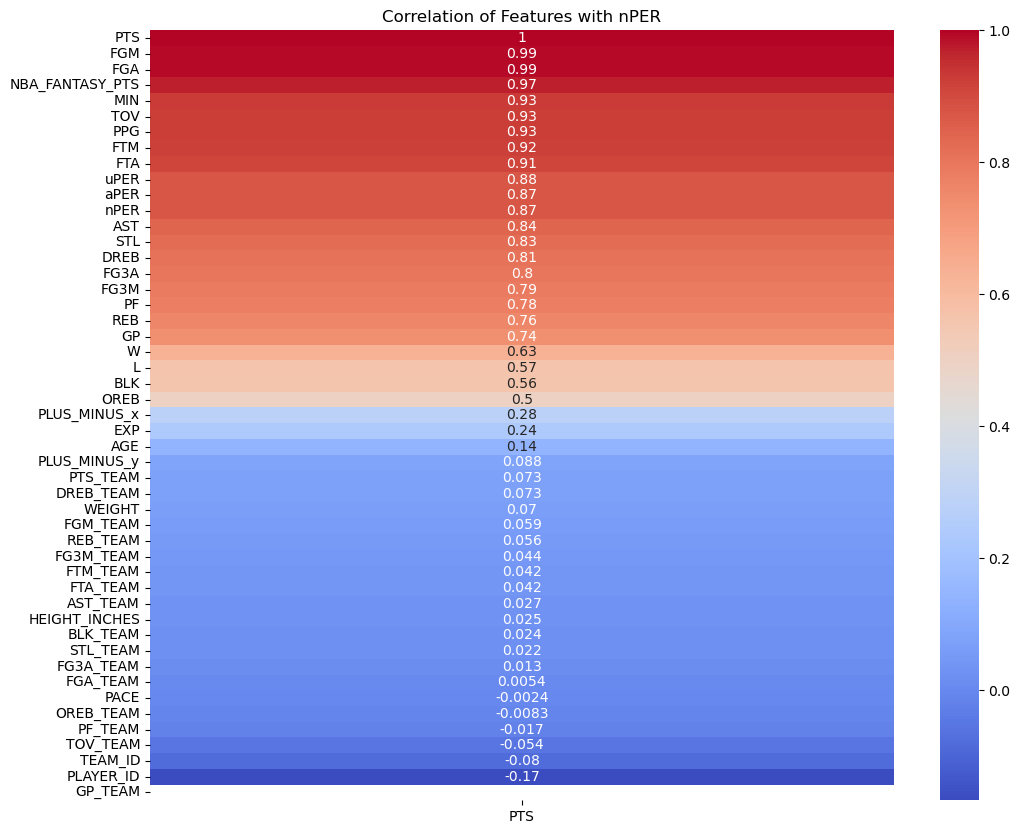

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot heatmap of correlations with nPER
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['PTS']].sort_values(by='PTS', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with nPER')
plt.show()


### 4. Feature Importance Using Mutual Information
Mutual information captures non-linear relationships between variables.


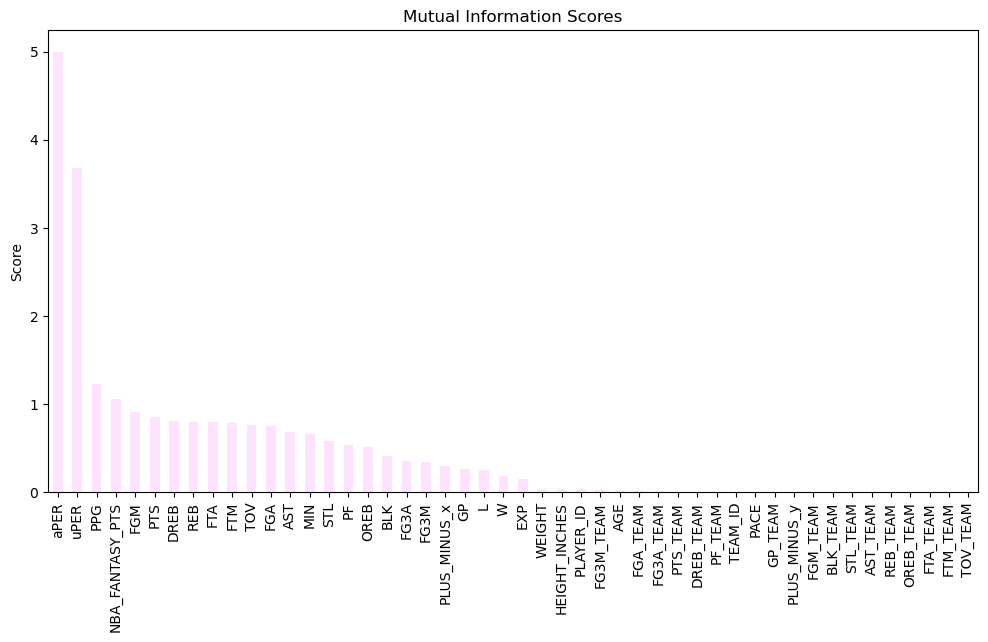

In [ ]:

from sklearn.feature_selection import mutual_info_regression

# Define features and target
X = df[numeric_features].drop('nPER', axis=1)
y = df['nPER']

# Compute mutual information
mi_scores = mutual_info_regression(X.fillna(0), y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot mutual information scores
plt.figure(figsize=(12, 6))
mi_scores.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.ylabel('Score')
plt.show()

### 5. Select Important Features
Based on correlation and mutual information, select the top features:

- Statistical Performance: PTS, AST, REB, STL, BLK, TOV
- Efficiency Metrics: FGM, FGA, FTM, FTA
- Physical Attributes: HEIGHT, WEIGHT, AGE
- Experience: EXP
- College: Encode SCHOOL if including college statistics

#### Part 2: Predictive Modeling

1. Data Preparation
Prepare your feature matrix X and target vector y.


In [ ]:
df.columns

Index(['SEASON', 'PLAYER_ID', 'PLAYER', 'GP', 'W', 'L', 'MIN', 'FGM', 'FGA',
       'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
       'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS_x', 'NBA_FANTASY_PTS',
       'POSITION', 'HEIGHT', 'WEIGHT', 'BIRTH_DATE', 'AGE', 'EXP', 'SCHOOL',
       'HOW_ACQUIRED', 'TEAM_ID', 'TEAM_NAME', 'GP_TEAM', 'FGM_TEAM',
       'FGA_TEAM', 'FG3M_TEAM', 'FG3A_TEAM', 'FTM_TEAM', 'FTA_TEAM',
       'OREB_TEAM', 'DREB_TEAM', 'REB_TEAM', 'AST_TEAM', 'TOV_TEAM',
       'STL_TEAM', 'BLK_TEAM', 'PF_TEAM', 'PTS_TEAM', 'PLUS_MINUS_y', 'PPG',
       'PACE', 'uPER', 'aPER', 'nPER', 'HEIGHT_INCHES'],
      dtype='object')

In [ ]:

# Selected features
selected_features = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV', 'FGM', 'FGA', 'FTM', 'FTA', 'AGE', 'EXP', 'HEIGHT_INCHES', 'WEIGHT']

X = df[selected_features]
y = df['nPER']

# Handle missing values
X = X.fillna(0)

In [ ]:
encoded_EXP = []
for i in X['EXP']:
    if i == 'R':
        exp_level = 1
    else:
        exp_level = i
    encoded_EXP.append(exp_level)

X['EXP'] = encoded_EXP

2. Encode Categorical Variables
If you have categorical variables like POSITION or SCHOOL, encode them.

In [ ]:
# Example: Encode 'POSITION'
#X = pd.concat([X, pd.get_dummies(merged_df3['POSITION'], prefix='POS')], axis=1)

3. Split the Data
Split your data into training and testing sets.



In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X

,PTS,AST,REB,STL,BLK,TOV,FGM,FGA,FTM,FTA,AGE,EXP,HEIGHT_INCHES,WEIGHT
0,896.0,203,488.0,67,47.0,101.0,359,702,107,147,22.0,2.0,80,219
1,83.0,92,51.0,11,3.0,20.0,34,90,13,17,26.0,3.0,76,210
2,14.0,0,7.0,0,0.0,1.0,4,17,3,4,24.0,0.0,76,220
3,81.0,27,33.0,7,5.0,10.0,34,92,4,8,20.0,0.0,77,195
4,1753.0,502,416.0,111,24.0,201.0,672,1463,208,262,27.0,6.0,77,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,199.0,29,146.0,11,27.0,15.0,80,183,11,20,21.0,2.0,81,203
518,99.0,76,24.0,9,3.0,29.0,37,91,14,19,30.0,0.0,75,188
519,333.0,145,125.0,48,3.0,56.0,125,276,44,58,23.0,2.0,75,178
520,1279.0,175,315.0,66,42.0,132.0,476,1083,143,173,21.0,0.0,79,200


#### Regression Models

4. Linear Regression
Implement a Linear Regression model.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error

# Initialize and fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred = lr_model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print(f'Linear Regression RMSE: {rmse:.2f}')
print(f'Linear Regression MSE: {mse:.2f}')
print(f'Linear Regression R² Score: {r2:.2f}')

Linear Regression RMSE: 4.43
Linear Regression MSE: 19.66
Linear Regression R² Score: 0.78







5. Regularized Regression
Use Ridge and Lasso Regression to handle multicollinearity.

python
Copy code
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge Regression MSE: {mse_ridge:.2f}')

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Lasso Regression MSE: {mse_lasso:.2f}')
Classification Models